# **Cluster Profiling and Behavioral Segmentation Analysis.**
Este notebook tiene como objetivo analizar y caracterizar los grupos de clientes generados en la fase previa de modelado de clustering, en la cual se aplicaron técnicas de reducción de dimensionalidad (PCA, t-SNE) y agrupamiento no supervisado.

La interpretación de los clusters es clave para convertir los resultados algorítmicos en conocimiento accionable. A través del análisis descriptivo de cada grupo, se busca:

- Identificar patrones comunes en variables demográficas, económicas y digitales
- Detectar perfiles con riesgo de abandono o alto valor
- Validar la coherencia del modelo a nivel de negocio
- Preparar la base para recomendaciones estratégicas y personalización de campañas

La caracterización se realizará mediante estadísticas descriptivas, visualizaciones comparativas (boxplots, barras, mapas si aplica) y segmentación simbólica.

Este paso es esencial para traducir el trabajo técnico en insights útiles para stakeholders y equipos de marketing o fidelización.

## **Importación de librerías y configuración general.**
Se cargan las librerías necesarias (incluidas en el archivo `requirements.txt`) para trabajar con bases de datos, manipulación de datos y archivos. También se desactivan ciertos mensajes de advertencia que podrían ensuciar la salida.

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import numpy as np
from sklearn.manifold import TSNE
import json
import matplotlib.colors as mcolors


warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

## **Importación e información del Dataframe.**
En esta sección se importa el conjunto de datos ya codificado y limpio, generado en el notebook anterior. Se verifican su forma y características básicas para asegurar consistencia antes de aplicar modelos.

In [103]:
df = pd.read_csv('../data/processed/IA_Client_Segment_sample_v2.csv', index_col=0)
df.head()

,Genero,Casado,Edad,Graduado,Experiencia_laboral,Gastoscore,Family_Size,Generacion,Ingresos_anuales_brutos,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Profesion_Construcción,Profesion_Empresarial,Profesion_Funcionario,Profesion_Otros,Profesion_Servicios,Profesion_Técnico,Zona_Centro,Zona_Levante,Zona_Noreste,Zona_Noroeste,Zona_Norte,Zona_Periferia,Zona_Sur,Campaña__0,Campaña__1,Campaña__3,Campaña__4,Campaña__5,Cluster_PCA,Cluster_tSNE,t-SNE1,t-SNE2,PC1,PC2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CLI10,0,1,67,1,2,0,3,1,93442,1385,80,1,195,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,2,1,-54.064560,-26.059683,-1.576538,-0.509218
CLI100,1,1,64,1,2,1,2,1,99774,1052,50,1,360,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,3,-24.174543,10.518461,-1.851295,-0.025332
CLI1000,1,1,65,1,2,1,3,1,36756,1717,30,0,407,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,4,3,-27.951586,48.194200,-0.779062,0.652867
CLI10000,1,0,33,0,1,0,4,2,24616,1606,30,0,544,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2,8.832579,4.512604,1.964895,0.213035
CLI10001,1,1,52,0,2,1,2,1,29834,1346,30,1,170,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,4,3,-13.865686,4.270164,-0.518938,0.232748


In [104]:
df.columns

Index(['Genero', 'Casado', 'Edad', 'Graduado', 'Experiencia_laboral',
       'Gastoscore', 'Family_Size', 'Generacion', 'Ingresos_anuales_brutos',
       'Digital_encuesta', 'Gasto_medio_mensual_cuota', 'Abandono',
       'Dias_cliente', 'Profesion_Construcción', 'Profesion_Empresarial',
       'Profesion_Funcionario', 'Profesion_Otros', 'Profesion_Servicios',
       'Profesion_Técnico', 'Zona_Centro', 'Zona_Levante', 'Zona_Noreste',
       'Zona_Noroeste', 'Zona_Norte', 'Zona_Periferia', 'Zona_Sur',
       'Campaña__0', 'Campaña__1', 'Campaña__3', 'Campaña__4', 'Campaña__5',
       'Cluster_PCA', 'Cluster_tSNE', 't-SNE1', 't-SNE2', 'PC1', 'PC2'],
      dtype='object')

## **Evaluación de la calidad de la segmentación.**
Antes de avanzar con la interpretación de los clusters, es esencial validar que la segmentación obtenida es **coherente, robusta y estructuralmente sólida**.

En esta sección se realizará una evaluación técnica de la calidad de los grupos obtenidos, utilizando tres enfoques complementarios:

1. **Matriz de coincidencia entre los clusters generados con PCA y su proyección en t-SNE**: Esto permite verificar si la segmentación basada en reducción lineal (PCA) se mantiene coherente en un espacio no lineal (t-SNE), lo cual indica estabilidad estructural.

2. **Visualización comparativa de clusters**: Se proyectarán los resultados en los planos PCA y t-SNE para evaluar la separación visual de los grupos y la consistencia espacial.

3. **Cálculo del Índice de Segmentación**: Se calculará una métrica interna que compara la **varianza intra-cluster frente a la varianza total**, lo cual permite cuantificar el nivel de diferenciación entre los grupos.

Este análisis conjunto permite justificar la validez técnica de los clusters obtenidos y aporta confianza para continuar con su interpretación estratégica.

### **Matriz de coincidencia entre PCA y t-SNE.**
Para validar la solidez estructural de la segmentación obtenida mediante PCA, se compara su asignación de clusters con la agrupación visual proyectada en el espacio t-SNE.

Esta matriz permite observar hasta qué punto **los grupos formados en un espacio lineal (PCA)** se mantienen **coherentes cuando los datos se representan de forma no lineal** mediante t-SNE.

Un alto grado de coincidencia entre ambos métodos indica que los clusters no son artificios del modelo, sino que reflejan **estructuras reales presentes en el comportamiento de los clientes**, fortaleciendo la confianza en la segmentación obtenida.

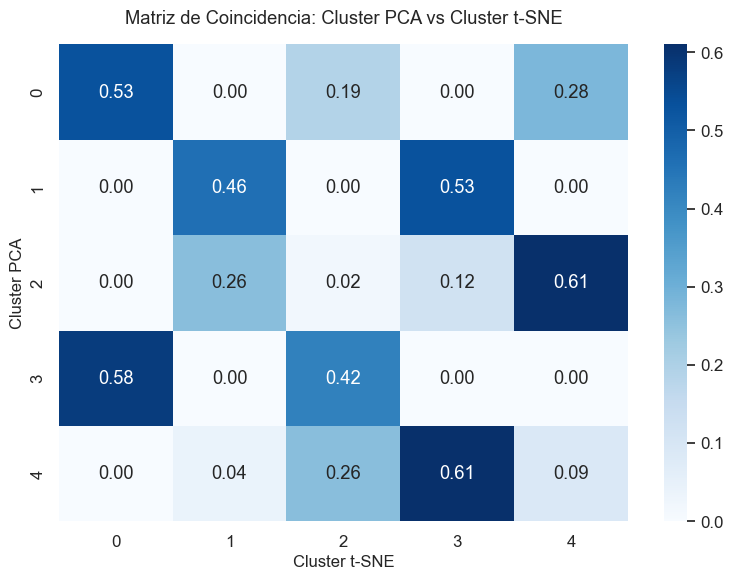

In [105]:
# Matriz de coincidencia.
coincidence_matrix = pd.crosstab(df['Cluster_PCA'], df['Cluster_tSNE'], normalize='index').round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(coincidence_matrix, annot=True, cmap="Blues", cbar=True, fmt=".2f")
plt.title("Matriz de Coincidencia: Cluster PCA vs Cluster t-SNE", pad=15)
plt.xlabel("Cluster t-SNE", fontsize=12)
plt.ylabel("Cluster PCA", fontsize=12)
plt.tight_layout()
plt.show()

**Conclusiones:**
1. **Cluster PCA 0 tiene buena coincidencia con t-SNE 0**, y una coincidencia secundaria con t-SNE 4: Esto indica una **división parcial**: parte del Cluster 0 en PCA se redistribuye en varios grupos en t-SNE.

2. **Cluster PCA 1 se divide principalmente entre t-SNE 1 y t-SNE 3**: Muestra una **segmentación clara pero partida en dos**, posiblemente porque t-SNE detecta una subestructura dentro del mismo grupo.

3. **Cluster PCA 2 se traslada mayoritariamente a t-SNE 4**, aunque con algo de dispersión: Este cluster se **mantiene bastante bien identificado**.

4. **Cluster PCA 3 tiene una coincidencia fuerte con t-SNE 0 y 2:** Esto sugiere que **t-SNE redistribuye este grupo en dos segmentos principales** que PCA no separó.

5. **Cluster PCA 4 coincide especialmente con t-SNE 3** y parcialmente con t-SNE 2: Buena correspondencia con t-SNE 3.

**Interpretación global:**

- Existen varias **correspondencias claras**, pero también **redistribuciones** interesantes entre clusters cuando se pasa de PCA a t-SNE.
- Esto sugiere que **t-SNE detecta subgrupos o transiciones suaves** dentro de clusters que PCA dejó más homogéneos.
- Es una señal de que **los clusters son globalmente consistentes**, pero t-SNE podría estar captando **mayor complejidad local o estructura no lineal** en los datos.

### **Visualización comparativa de clusters en PCA y t-SNE.**
Tras validar cuantitativamente la coherencia entre los clusters obtenidos con PCA y su representación en t-SNE, en esta sección se busca **evaluar visualmente la calidad y separación de los grupos** en ambos espacios.

La representación gráfica permite observar:
- La **distribución espacial** de los clientes según los primeros dos componentes principales del PCA.
- Cómo se **agrupan los clientes en el espacio no lineal** de t-SNE.
- La **compacidad, separación y forma** de los clusters desde distintas perspectivas.

Esta comparación no solo refuerza la solidez técnica del modelo PCA, sino que también ayuda a **identificar posibles solapamientos o subgrupos** que podrían tener implicaciones estratégicas.

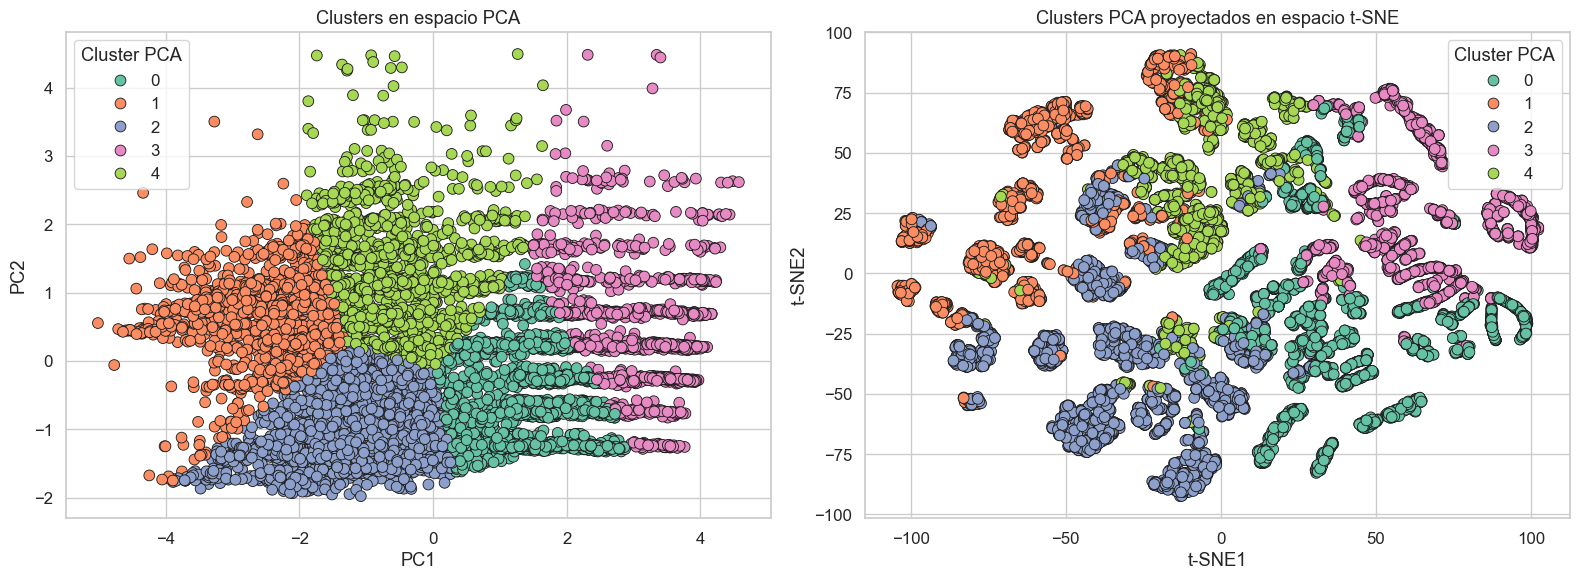

In [106]:
# Gráfica de dispersión de los clusters PCA y t-SNE.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA.
sns.scatterplot(
    data=df, x="PC1", y="PC2", hue="Cluster_PCA", palette="Set2",
    ax=axes[0], s=60, edgecolor='k'
)
axes[0].set_title("Clusters en espacio PCA")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend(title='Cluster PCA', loc='best')

# t-SNE.
sns.scatterplot(
    data=df, x="t-SNE1", y="t-SNE2", hue="Cluster_PCA", palette="Set2",
    ax=axes[1], s=60, edgecolor='k'
)
axes[1].set_title("Clusters PCA proyectados en espacio t-SNE")
axes[1].set_xlabel("t-SNE1")
axes[1].set_ylabel("t-SNE2")
axes[1].legend(title='Cluster PCA', loc='best')

plt.tight_layout()
plt.show()

**Interpretación.**
1. **Estructuras claras**: El gráfico de t-SNE muestra grupos **bien definidos**, sin mezcla caótica. Eso indica que los datos que recibió t-SNE ya estaban **bien representados**, lo cual habla bien del PCA.

2. **Grupos con formas limpias**: Aunque t-SNE tiende a separar todo, la forma en que se agrupan los puntos no parece artificial. Eso sugiere que el **PCA no aplastó ni distorsionó la estructura interna**.

3. **Colores (clusters) siguen siendo consistentes**: Los mismos clusters definidos en PCA se proyectan de forma **coherente** en t-SNE. Si el PCA hubiera perdido demasiada información, t-SNE no podría haber recuperado estas formas.

En conjunto, esta proyección **refuerza la validez del modelo de PCA**, demostrando que los grupos detectados reflejan patrones reales del comportamiento del cliente, y no son un resultado artificial de la técnica.

In [107]:
df[['PC1', 'PC2', 'Cluster_PCA']].rename(columns={'Cluster_PCA': 'Cluster'}) \
    .to_csv('../data/report/IA_Client_Segment_sample_PCA.csv', index=False)

In [108]:
df.drop(columns=['Cluster_tSNE', 't-SNE1', 't-SNE2', 'PC1', 'PC2'], inplace=True) # Eliminación de columnas innecesarias.

## **Perfilado de variables por cluster: Índice por variable.**
Para comprender en profundidad las características que definen cada grupo, es fundamental analizar cómo se comportan las variables originales dentro de cada cluster. Con este fin, se ha calculado un **índice de caracterización por variable**, el cual permite identificar las dimensiones más representativas en cada segmento.

Este índice se define como el **cociente entre el valor medio de una variable dentro de un cluster y su valor medio global** en todo el dataset:

$$
\text{Índice}_{\text{variable}} = \frac{\text{Media de la variable en el cluster}}{\text{Media global de la variable}}
$$


- Si el índice es **mayor que 1**, la variable está **sobrerrepresentada** en ese cluster, y por tanto puede actuar como un **rasgo diferenciador positivo**.
- Si el índice es **menor que 1**, la variable está **infrarrepresentada**, lo que puede indicar una **ausencia significativa o una tendencia inversa**.
- Si el índice es cercano a **1**, el comportamiento del cluster respecto a esa variable es **similar al promedio general**.

Este análisis permite identificar rápidamente **qué características distinguen a cada cluster**, y se convierte en una herramienta clave para el **naming estratégico de segmentos**, la **definición de perfiles de cliente** y el diseño de **acciones personalizadas en campañas de marketing** o decisiones de negocio.

In [109]:
variables_numericas = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Cluster_PCA'], errors='ignore').columns

In [110]:
# Selección de variables numéricas para el análisis.
variables_numericas = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Cluster_PCA'], errors='ignore').columns

# Cálculo de medias.
media_global = df[variables_numericas].mean()
media_por_cluster = df.groupby('Cluster_PCA')[variables_numericas].mean()

# Índice por variable = media en cluster / media global.
indice_por_variable = media_por_cluster.div(media_global).round(2)

In [111]:
indice_por_variable

,Genero,Casado,Edad,Graduado,Experiencia_laboral,Gastoscore,Family_Size,Generacion,Ingresos_anuales_brutos,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Profesion_Construcción,Profesion_Empresarial,Profesion_Funcionario,Profesion_Otros,Profesion_Servicios,Profesion_Técnico,Zona_Centro,Zona_Levante,Zona_Noreste,Zona_Noroeste,Zona_Norte,Zona_Periferia,Zona_Sur,Campaña__0,Campaña__1,Campaña__3,Campaña__4,Campaña__5
Cluster_PCA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.91,0.52,0.73,1.01,0.60,0.28,0.83,1.35,0.55,1.03,0.70,0.98,1.00,1.84,0.58,1.39,1.20,0.68,1.37,1.09,0.98,1.02,0.97,1.01,0.98,0.95,1.00,0.95,1.03,1.07,0.93
1,1.02,1.69,1.45,1.16,1.43,2.77,0.98,0.49,1.58,0.78,1.62,1.07,1.01,0.49,1.48,0.04,0.65,1.58,0.54,1.00,1.09,0.97,1.02,0.93,0.99,1.00,1.00,0.88,0.99,0.98,1.06
2,0.95,1.09,1.19,1.26,1.41,0.27,0.58,0.68,1.38,0.90,1.23,0.98,1.00,0.91,0.56,0.19,1.15,1.43,0.92,0.98,0.94,1.01,1.00,1.08,1.00,0.99,0.99,1.77,0.86,0.82,1.04
3,1.06,0.16,0.55,0.33,0.10,0.14,1.57,1.72,0.38,1.47,0.66,0.97,0.98,0.62,0.85,3.65,0.59,0.18,0.96,0.95,1.07,0.99,1.04,0.93,1.00,1.01,1.03,0.08,1.16,1.16,0.94
4,1.14,1.65,1.06,1.03,1.32,2.28,1.42,0.86,1.01,0.91,0.74,1.02,1.01,0.84,2.00,0.18,1.22,0.95,1.12,0.96,0.97,0.98,1.00,0.98,1.04,1.07,0.99,0.79,1.05,1.06,1.03


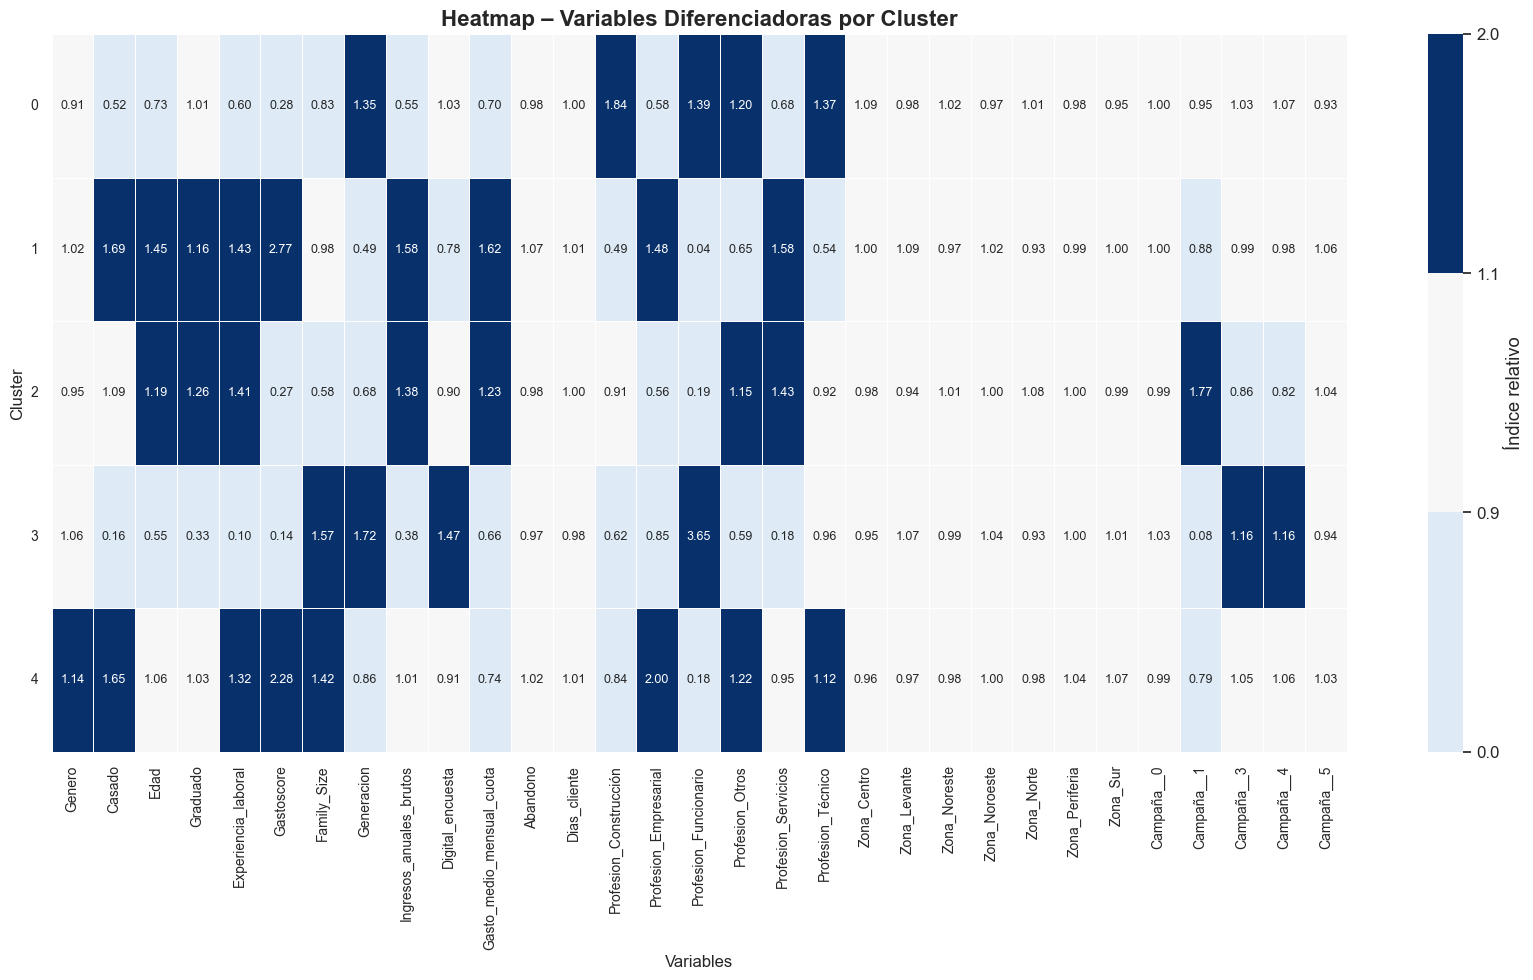

In [112]:
cmap_blue = mcolors.LinearSegmentedColormap.from_list(
    "blue_gradient", ["#deebf7", "#f7f7f7", "#08306b"], N=256
)
norm_blue = mcolors.BoundaryNorm([0, 0.9, 1.1, 2], cmap_blue.N)

plt.figure(figsize=(17, 10))
sns.heatmap(
    indice_por_variable,
    annot=True,
    cmap=cmap_blue,
    norm=norm_blue,
    linewidths=0.4,
    fmt=".2f",
    cbar_kws={'label': 'Índice relativo'},
    annot_kws={"size": 9}
)

plt.title("Heatmap – Variables Diferenciadoras por Cluster", fontsize=16, fontweight='bold')
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [113]:
indice_por_variable.to_csv('../data/report/IA_Client_Segment_sample_Index.csv')

Una vez calculado el índice por característica, es posible realizar una lectura estratégica y descriptiva de los perfiles que emergen en cada cluster. Este análisis permite identificar qué dimensiones definen a cada grupo, ya sea por su sobre-representación (índice > 1) o por su sub-representación (índice < 1).

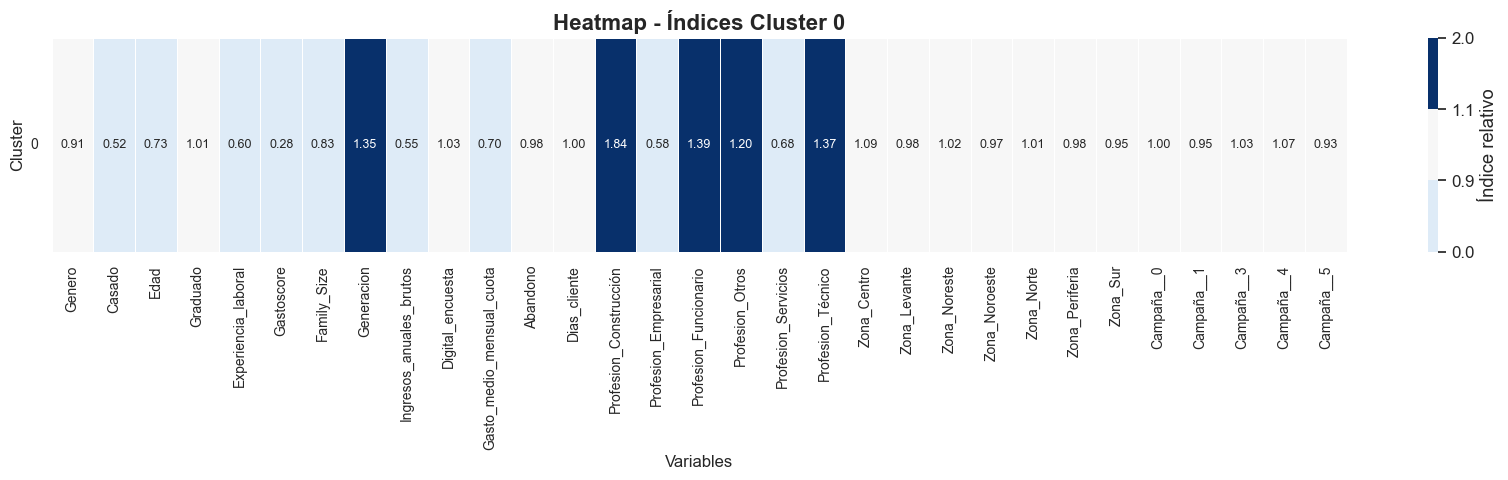

In [114]:
# Cluster 0: Evaluación de variables.
plt.figure(figsize=(17, 5))
sns.heatmap(
    indice_por_variable.loc[[0]],
    annot=True,
    cmap=cmap_blue,
    norm=norm_blue,
    linewidths=0.4,
    fmt=".2f",
    cbar_kws={'label': 'Índice relativo'},
    annot_kws={"size": 9}
)

plt.title("Heatmap - Índices Cluster 0", fontsize=16, fontweight='bold')
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

**Diagnóstico Cluster 0.** Este segmento representa un grupo de **clientes jóvenes, con bajo poder adquisitivo, escasa experiencia laboral y menor participación histórica**, pero que **muestran señales de activación reciente**. A continuación, se resumen sus principales rasgos y cómo deben ser tratados estratégicamente:

| Categoría                  | Tendencia general         |
|---------------------------|---------------------------|
| Edad y etapa vital        | ⇩ Jóvenes                 |
| Ingresos y gasto          | ⇩ Bajo poder adquisitivo  |
| Educación y estado civil  | ≈ Formación media y ⇩ menor probabilidad de estar casado |
| Experiencia laboral       | ⇩ Trayectoria inicial     |
| Profesión                 | ⇧ Técnicos, funcionarios y construcción |
| Digitalización            | ⇧ Ligeramente superior    |
| Respuesta a campañas      | ⇧ Mejores resultados en campañas recientes |

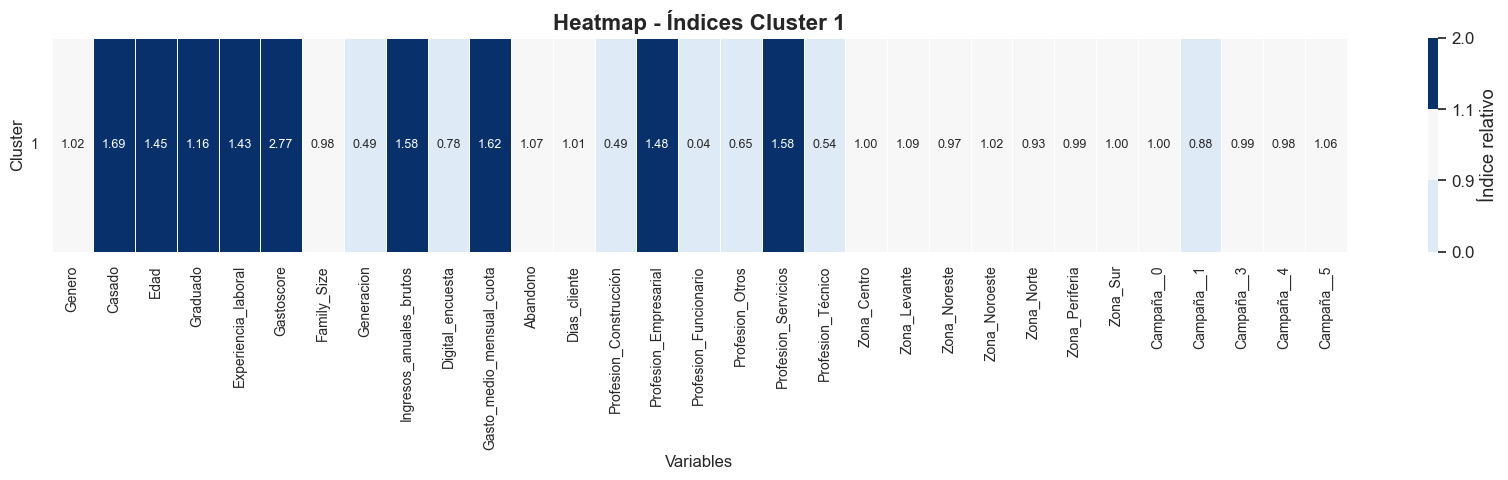

In [115]:
# Cluster 1: Evaluación de variables.
plt.figure(figsize=(17, 5))
sns.heatmap(
    indice_por_variable.loc[[1]],
    annot=True,
    cmap=cmap_blue,
    norm=norm_blue,
    linewidths=0.4,
    fmt=".2f",
    cbar_kws={'label': 'Índice relativo'},
    annot_kws={"size": 9}
)

plt.title("Heatmap - Índices Cluster 1", fontsize=16, fontweight='bold')
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

**Diagnóstico Cluster 1.** Este grupo representa un **perfil mayor y económicamente consolidado**, formado por clientes con **alta experiencia laboral, elevados ingresos y fuerte nivel de gasto**. Además, presenta una **alta proporción de personas casadas y graduadas**, lo que sugiere estabilidad social y profesional.

Aunque su tamaño familiar es más reducido, esto probablemente se deba a su **etapa vital avanzada** (por ejemplo, parejas sin hijos a cargo o personas con hijos ya independizados). Su menor nivel de digitalización refuerza esta hipótesis generacional.

Es un segmento ideal para **estrategias de fidelización, servicios premium o productos financieros avanzados**, donde la rentabilidad por cliente es clave.


| Categoría                  | Tendencia general                     |
|---------------------------|----------------------------------------|
| Edad y etapa vital        | ⇧ Mayores con amplia trayectoria       |
| Estado civil              | ⇧ Alta proporción de casados           |
| Ingresos y gasto          | ⇧ Poder adquisitivo elevado            |
| Educación                 | ⇧ Mayor proporción de graduados        |
| Profesión                 | ⇧ Servicios y perfil ejecutivo         |
| Tamaño familiar           | ≈ En la media, asociado a etapa post-familiar |
| Digitalización            | ⇩ Menor interacción digital            |
| Generación                | ⇩ Predominio de generaciones mayores   |
| Respuesta comercial       | ≈ Participación moderada, con ligera respuesta reciente   |

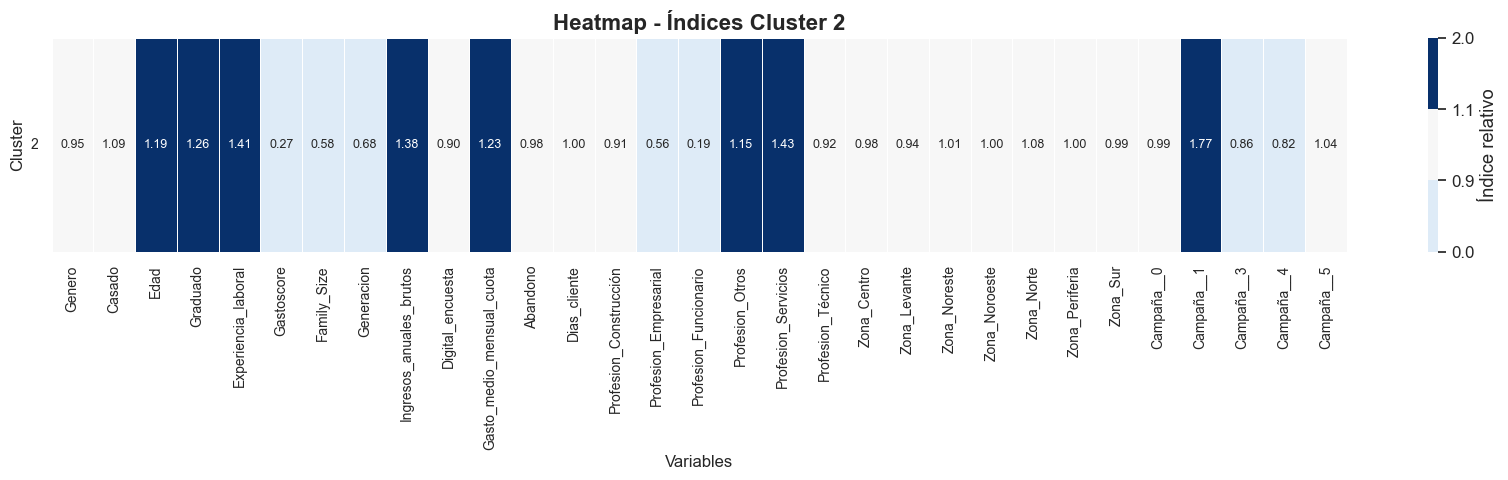

In [116]:
# Cluster 2: Evaluación de variables.
plt.figure(figsize=(17, 5))
sns.heatmap(
    indice_por_variable.loc[[2]],
    annot=True,
    cmap=cmap_blue,
    norm=norm_blue,
    linewidths=0.4,
    fmt=".2f",
    cbar_kws={'label': 'Índice relativo'},
    annot_kws={"size": 9}
)

plt.title("Heatmap - Índices Cluster 2", fontsize=16, fontweight='bold')
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

**Diagnóstico Cluster 2.** Este grupo representa a **clientes con buen nivel económico**, que **ganan bien y gastan bastante cada mes**. Aunque su **Gasto Score aparece como bajo**, eso no significa que gasten poco, sino que **gestionan bien su dinero**: tienen **poca deuda y no dependen de financiación externa**, lo que refleja una **situación financiera sólida**.

Son personas **ligeramente mayores que el promedio**, con **más experiencia laboral y mayor nivel educativo**. Viven en **hogares pequeños**, posiblemente por estar en una etapa de vida más individual o con menos cargas familiares.

Aunque no responden mucho a la mayoría de campañas, **sí reaccionan muy bien a campañas específicas**, como la Campaña 1. Esto sugiere que **no se dejan influenciar fácilmente**, pero **sí responden cuando la oferta les interesa**.

Son ideales para estrategias de **fidelización personalizada, productos de valor medio-alto y promociones bien enfocadas**, ya que tienen **capacidad de compra y son exigentes con lo que eligen**.


| Categoría                  | Tendencia general                                              |
|---------------------------|----------------------------------------------------------------|
| Ingresos y gasto          | ⇧ Altos ingresos y gasto mensual elevado                      |
| Edad                      | ⇧ Ligeramente mayores                                           |
| Educación y experiencia   | ⇧ Más formados y con más años de experiencia laboral           |
| Gastoscore                | ⇩ Bajo (pero refleja buena salud financiera, no bajo gasto)    |
| Tamaño familiar           | ⇩ Hogares pequeños                                              |
| Campaña 1                 | ⇧ Alta participación puntual                                    |
| Otras campañas            | ⇩ Menor respuesta (comportamiento más selectivo)               |
| Profesión                 | ⇧ Predominio de servicios y perfiles diversos                  |
| Digitalización            | ⇩ Algo menor al promedio                                       |

**Diferencia clave con Cluster 1.** A primera vista se puden ver similares, pero hay diferencias notorias:
- Cluster 1 representa un perfil más tradicional: adultos mayores, casados, graduados, de profesión estable, con alta capacidad de gasto y una base relacional sólida.
- Cluster 2 es más económicamente enfocado: clientes con poder adquisitivo, que gastan mucho, pero con estructura familiar más reducida y un comportamiento más selectivo ante campañas.

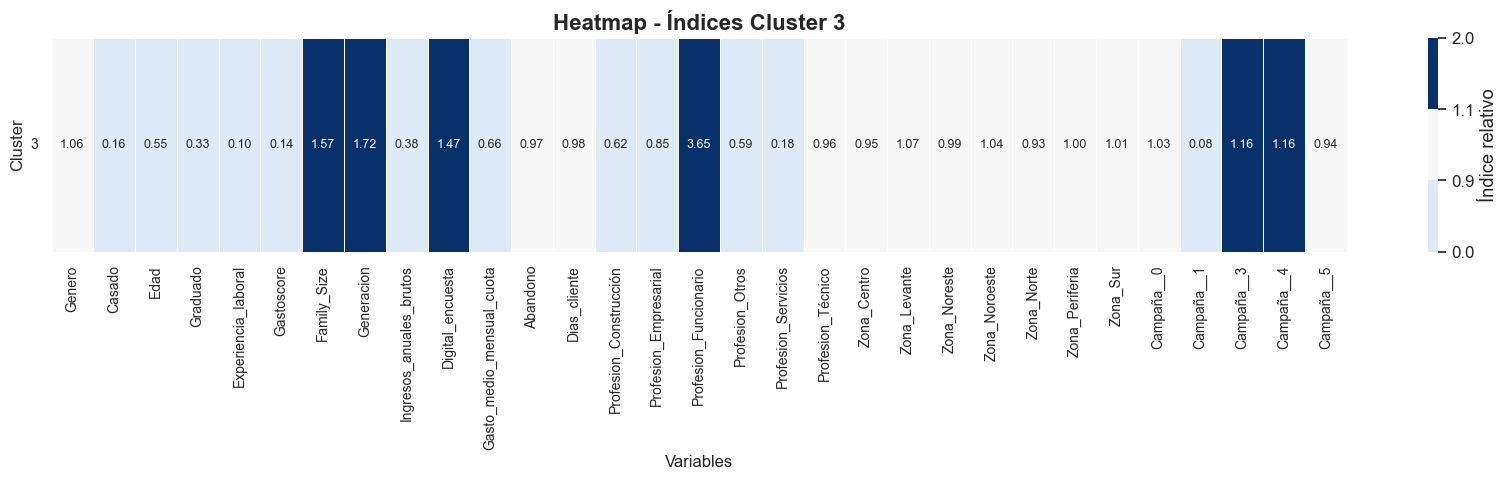

In [117]:
# Cluster 3: Evaluación de variables.
plt.figure(figsize=(17, 5))
sns.heatmap(
    indice_por_variable.loc[[3]],
    annot=True,
    cmap=cmap_blue,
    norm=norm_blue,
    linewidths=0.4,
    fmt=".2f",
    cbar_kws={'label': 'Índice relativo'},
    annot_kws={"size": 9}
)

plt.title("Heatmap - Índices Cluster 3", fontsize=16, fontweight='bold')
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

**Diagnóstico Cluster 3.** Este grupo representa a **clientes jóvenes con ingresos bajos, bajo nivel educativo y menor gasto mensual**, pero con un perfil muy **activo digitalmente** y **fuertemente orientado a la vida familiar**, como sugiere el **mayor tamaño del hogar**.

A pesar de no estar casados en su mayoría y tener un nivel educativo bajo, presentan una **fuerte concentración en empleos públicos**, lo que podría ofrecer cierta estabilidad laboral, aunque con **limitado poder adquisitivo**.

Son **poco receptivos a campañas tradicionales**, como la Campaña 1, pero **responden mejor a campañas más recientes**, lo que sugiere una mayor **apertura a canales digitales o a mensajes más modernos y personalizados**.

Este perfil tiene **potencial de crecimiento** si se trabaja desde **plataformas online**, con **contenidos adaptados a jóvenes con familias y preferencias digitales**.


| Categoría                  | Tendencia general                                                |
|---------------------------|------------------------------------------------------------------|
| Edad                      | ⇩ Muy jóvenes                                                    |
| Ingresos y gasto          | ⇩ Bajos ingresos y gasto mensual limitado                        |
| Educación y estado civil  | ⇩ Nivel educativo bajo y pocos casados                           |
| Profesión                 | ⇧ Alta presencia de funcionarios                                 |
| Tamaño familiar           | ⇧ Hogares grandes (contexto familiar amplio)                     |
| Digitalización            | ⇧ Muy activos digitalmente                                       |
| Campaña 1                 | ⇩ Casi sin respuesta                                             |
| Campañas recientes        | ⇧ Buena respuesta en campañas 3 y 4                              |

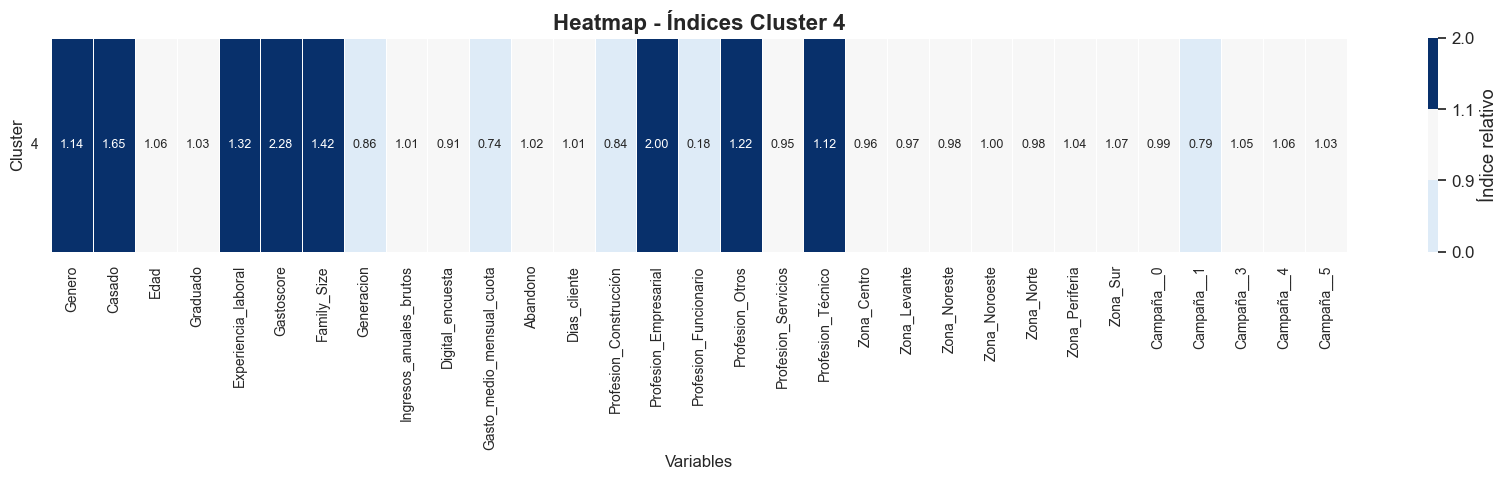

In [118]:
# Cluster 4: Evaluación de variables.
plt.figure(figsize=(17, 5))
sns.heatmap(
    indice_por_variable.loc[[4]],
    annot=True,
    cmap=cmap_blue,
    norm=norm_blue,
    linewidths=0.4,
    fmt=".2f",
    cbar_kws={'label': 'Índice relativo'},
    annot_kws={"size": 9}
)

plt.title("Heatmap - Índices Cluster 4", fontsize=16, fontweight='bold')
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

**Diagnóstico Cluster 4.** El Cluster 4 agrupa a **clientes algo mayores que la media, con estructuras familiares amplias y una sólida trayectoria laboral**, lo que sugiere **perfiles familiares consolidados** y con responsabilidades. 

A pesar de que su **gasto mensual reportado es bajo**, el sistema los clasifica con un **Gastoscore muy alto**, lo cual podría reflejar **potencial de consumo, uso de crédito o contratación de servicios de valor**.

Predominan los perfiles empresariales, lo cual refuerza la idea de **personas en posiciones de decisión**. Su nivel de digitalización es algo más bajo, y su respuesta a campañas tradicionales también lo es, aunque **empiezan a mostrar mejor receptividad a campañas más recientes**.

Este segmento podría beneficiarse de **estrategias mixtas**: tradicionales pero bien segmentadas, que conecten con su **responsabilidad familiar y su rol como tomadores de decisiones**.


| Categoría                  | Tendencia general                                                              |
|---------------------------|--------------------------------------------------------------------------------|
| Edad                      | ⇧ Ligeramente mayores                                                          |
| Tamaño familiar           | ⇧ Hogares más grandes (posible presencia de hijos/dependientes)               |
| Experiencia laboral       | ⇧ Trayectoria profesional larga                                               |
| Profesión                 | ⇧ Alta presencia de perfiles empresariales                                     |
| Gasto mensual             | ⇩ Gasto declarado más bajo                                                     |
| Gastoscore                | ⇧ Clasificación de alto potencial de gasto o uso financiero                    |
| Digitalización            | ⇩ Interacción digital algo menor                                               |
| Campaña 1                 | ⇩ Baja respuesta a estrategias clásicas                                        |
| Campañas recientes        | ≈ Leve mejor respuesta (moderadamente receptivos a nuevos enfoques)            |

### **Resumen Estratégico de Perfiles por Cluster.**

| Cluster | Perfil estratégico                                               |
|---------|------------------------------------------------------------------|
| **0**   | Clientes **jóvenes**, con **bajo poder adquisitivo** y menor experiencia laboral. Muestran **potencial digital** y responden a estímulos recientes. Ideal para estrategias de captación y fidelización temprana. |
| **1**   | Perfil **maduro, consolidado y estable**, con **altos ingresos y formación universitaria**. Hogares medianos, baja digitalización. Clientes ideales para **servicios premium y de largo plazo**. |
| **2**   | Grupo con **alto poder adquisitivo** y comportamiento **exigente y selectivo**. Aunque presentan **baja interacción digital** y hogares más reducidos, **sí cuentan con un buen nivel educativo y estabilidad laboral**, con fuerte presencia en profesiones de servicios. Ideales para **ofertas exclusivas, productos de valor percibido alto y campañas puntuales bien segmentadas**. |
| **3**   | Clientes **jóvenes, digitales y con familias grandes**, pero con **bajo nivel económico**. Potenciales usuarios de estrategias online, dinámicas y enfocadas a contextos familiares. |
| **4**   | Clientes **ligeramente mayores**, con **familias numerosas** y una **larga trayectoria profesional**. Aunque su **gasto mensual declarado es moderado**, su perfil financiero sugiere **alto potencial de consumo**. Presentan **baja interacción digital** y responden poco a campañas tradicionales, aunque se observa **cierta receptividad en acciones más recientes**. Su fuerte presencia en roles empresariales los convierte en candidatos ideales para **propuestas prácticas, familiares o con enfoque responsable y conservador**. |

## **Reconversión de variables dummy y ordinales a texto.**
En esta etapa se realiza la **reconversión de variables previamente transformadas durante la fase de modelado**, con el objetivo de facilitar su interpretación en el análisis descriptivo y visual de los clusters.

Durante la preparación de datos para técnicas como PCA, t-SNE o K-Means, muchas variables categóricas y ordinales fueron **codificadas numéricamente** o mediante **codificación One-Hot (dummies)**. Si bien estas transformaciones son necesarias para el funcionamiento de los algoritmos, resultan **poco legibles para análisis de negocio** o representación gráfica.

Por tanto, es imprescindible **restaurar sus valores originales o legibles** para que las visualizaciones, tablas comparativas e interpretaciones por cluster sean comprensibles y accionables por perfiles no técnicos.

Este proceso incluye:

- Reconversión de variables **ordinales** (e.g., experiencia laboral, score de gasto) mediante mapeo de códigos a etiquetas textuales.
- Reconstrucción de variables **categóricas originales** a partir de columnas dummy (e.g., profesión, zona, campaña).
- Transformación de variables **binarias 0/1** (e.g., casado, graduado, abandono) en etiquetas interpretables ("Sí", "No").

*Esto es clave para que los gráficos, tablas y análisis sean comprensibles para negocio.*

In [119]:
df_original = df.copy() # Dataset original.

In [120]:
# Ordinal Encoding: Variables categóricas con orden.
ordinal_map = {
    'Experiencia_laboral': ['<10annos', '10-20annos', '+20annos'],
    'Gastoscore': ['Bajo', 'Medio', 'Alto'],
    'Generacion': ['Generacion Silenciosa', 'Generacion X', 'Millennials', 'Generacion Z']
}
for col, categorias in ordinal_map.items():
    df[col] = df[col].apply(lambda x: categorias[int(x)] if pd.notnull(x) else x)

In [121]:
# One-Hot Encoding: Variables categóricas sin orden.
## Profesión.
prof_cols = [col for col in df.columns if 'Profesion_' in col]
df['Profesion'] = df[prof_cols].idxmax(axis=1).str.replace('Profesion_', '')

## Zona.
zona_cols = [col for col in df.columns if 'Zona_' in col]
df['Zona'] = df[zona_cols].idxmax(axis=1).str.replace('Zona_', '')

df.drop(columns=prof_cols + zona_cols, inplace=True) # Eliminación de columnas Dummy.

In [122]:
df.head()

,Genero,Casado,Edad,Graduado,Experiencia_laboral,Gastoscore,Family_Size,Generacion,Ingresos_anuales_brutos,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Campaña__0,Campaña__1,Campaña__3,Campaña__4,Campaña__5,Cluster_PCA,Profesion,Zona
ID,,,,,,,,,,,,,,,,,,,,,
CLI10,0,1,67,1,+20annos,Bajo,3,Generacion X,93442,1385,80,1,195,1,0,0,0,0,2,Técnico,Noroeste
CLI100,1,1,64,1,+20annos,Medio,2,Generacion X,99774,1052,50,1,360,0,0,0,0,1,1,Técnico,Levante
CLI1000,1,1,65,1,+20annos,Medio,3,Generacion X,36756,1717,30,0,407,0,0,1,0,0,4,Servicios,Centro
CLI10000,1,0,33,0,10-20annos,Bajo,4,Millennials,24616,1606,30,0,544,0,0,0,1,0,0,Funcionario,Noroeste
CLI10001,1,1,52,0,+20annos,Medio,2,Generacion X,29834,1346,30,1,170,1,0,0,0,0,4,Otros,Noreste


In [123]:
# Label Encoding: Variables binarias sin orden.
label_vars = ['Genero', 'Casado', 'Graduado', 'Abandono']
binary_map = {
    'Genero': {0: 'Femenino', 1: 'Masculino'},
    'Casado': {0: 'No', 1: 'Sí'},
    'Graduado': {0: 'No', 1: 'Sí'},
    'Abandono': {0: 'No', 1: 'Sí'}
}

for var in label_vars:
    df[var] = df[var].map(binary_map[var])

## **Descripción general de los clusters.**
En esta sección se presenta una visión global de la distribución de los clientes según el modelo de segmentación. A través del conteo y la proporción de observaciones por grupo, se identifica **el peso relativo de cada cluster**, lo cual es clave para **dimensionar su relevancia estratégica**.

Esta primera visualización permite entender la **estructura del dataset segmentado** y anticipar **dónde pueden encontrarse los perfiles dominantes o minoritarios**, como base para los análisis posteriores.

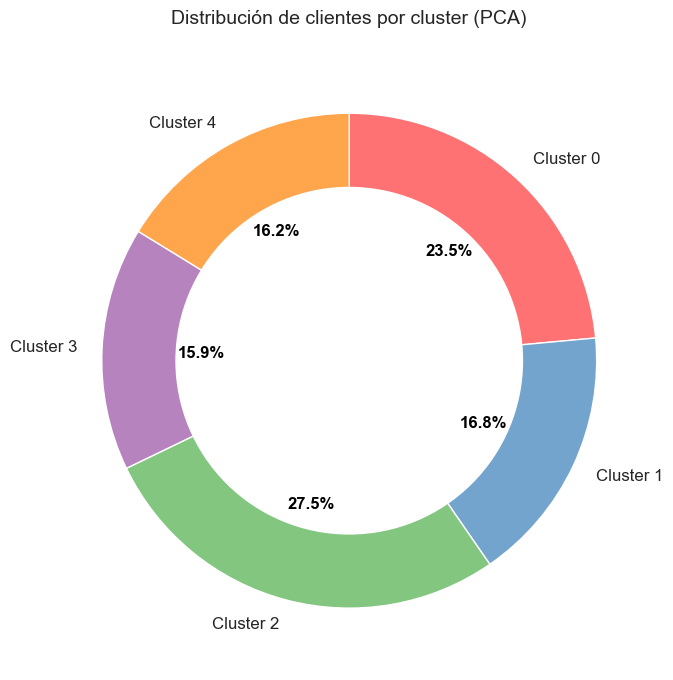

In [124]:
cluster_counts = df['Cluster_PCA'].value_counts().sort_index()
labels = [f"Cluster {i}" for i in cluster_counts.index]

# Colores hex específicos por cluster.
custom_colors = ['#FF7274', '#72A4CD', '#82C680', '#B683BE', '#FFA54C']

fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(cluster_counts,
                                  labels=labels,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  counterclock=False,
                                  colors=custom_colors[:len(cluster_counts)],
                                  wedgeprops={'width': 0.4, 'edgecolor': 'white'})

# Donut blanco en el centro.
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)
plt.setp(autotexts, size=12, weight="bold", color="black")
plt.title("Distribución de clientes por cluster (PCA)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [125]:
v_continuas = []
v_categoricas = []
for i in df.drop(columns=['Cluster_PCA']).columns:
    if df[i].nunique() > 55 or df[i].dtypes in ['float64', 'int64']:
        v_continuas.append(i)
    else:
        v_categoricas.append(i)

print('Variables continuas: {}'.format(', '.join(v_continuas)))
print('Variables categóricas: {}'.format(', '.join(v_categoricas)))

Variables continuas: Edad, Family_Size, Ingresos_anuales_brutos, Digital_encuesta, Gasto_medio_mensual_cuota, Dias_cliente, Campaña__0, Campaña__1, Campaña__3, Campaña__4, Campaña__5
Variables categóricas: Genero, Casado, Graduado, Experiencia_laboral, Gastoscore, Generacion, Abandono, Profesion, Zona


### **Caracterización por variables continuas.**
En esta sección analizamos cómo varían las variables numéricas entre los distintos clusters. Observamos aspectos como:
- La edad, los ingresos o el tamaño del hogar.
- Cuánto gastan al mes, cuánto tiempo llevan como clientes o su nivel de digitalización.
- Cuánto han interactuado con distintas campañas comerciales.

Gracias a los gráficos, podemos detectar en qué grupos hay personas más jóvenes, con más ingresos o más fidelizadas, lo que nos ayudará a entender mejor cada perfil y tomar decisiones adaptadas.

In [126]:
df[v_continuas].head(3)

,Edad,Family_Size,Ingresos_anuales_brutos,Digital_encuesta,Gasto_medio_mensual_cuota,Dias_cliente,Campaña__0,Campaña__1,Campaña__3,Campaña__4,Campaña__5
ID,,,,,,,,,,,
CLI10,67,3,93442,1385,80,195,1,0,0,0,0
CLI100,64,2,99774,1052,50,360,0,0,0,0,1
CLI1000,65,3,36756,1717,30,407,0,0,1,0,0


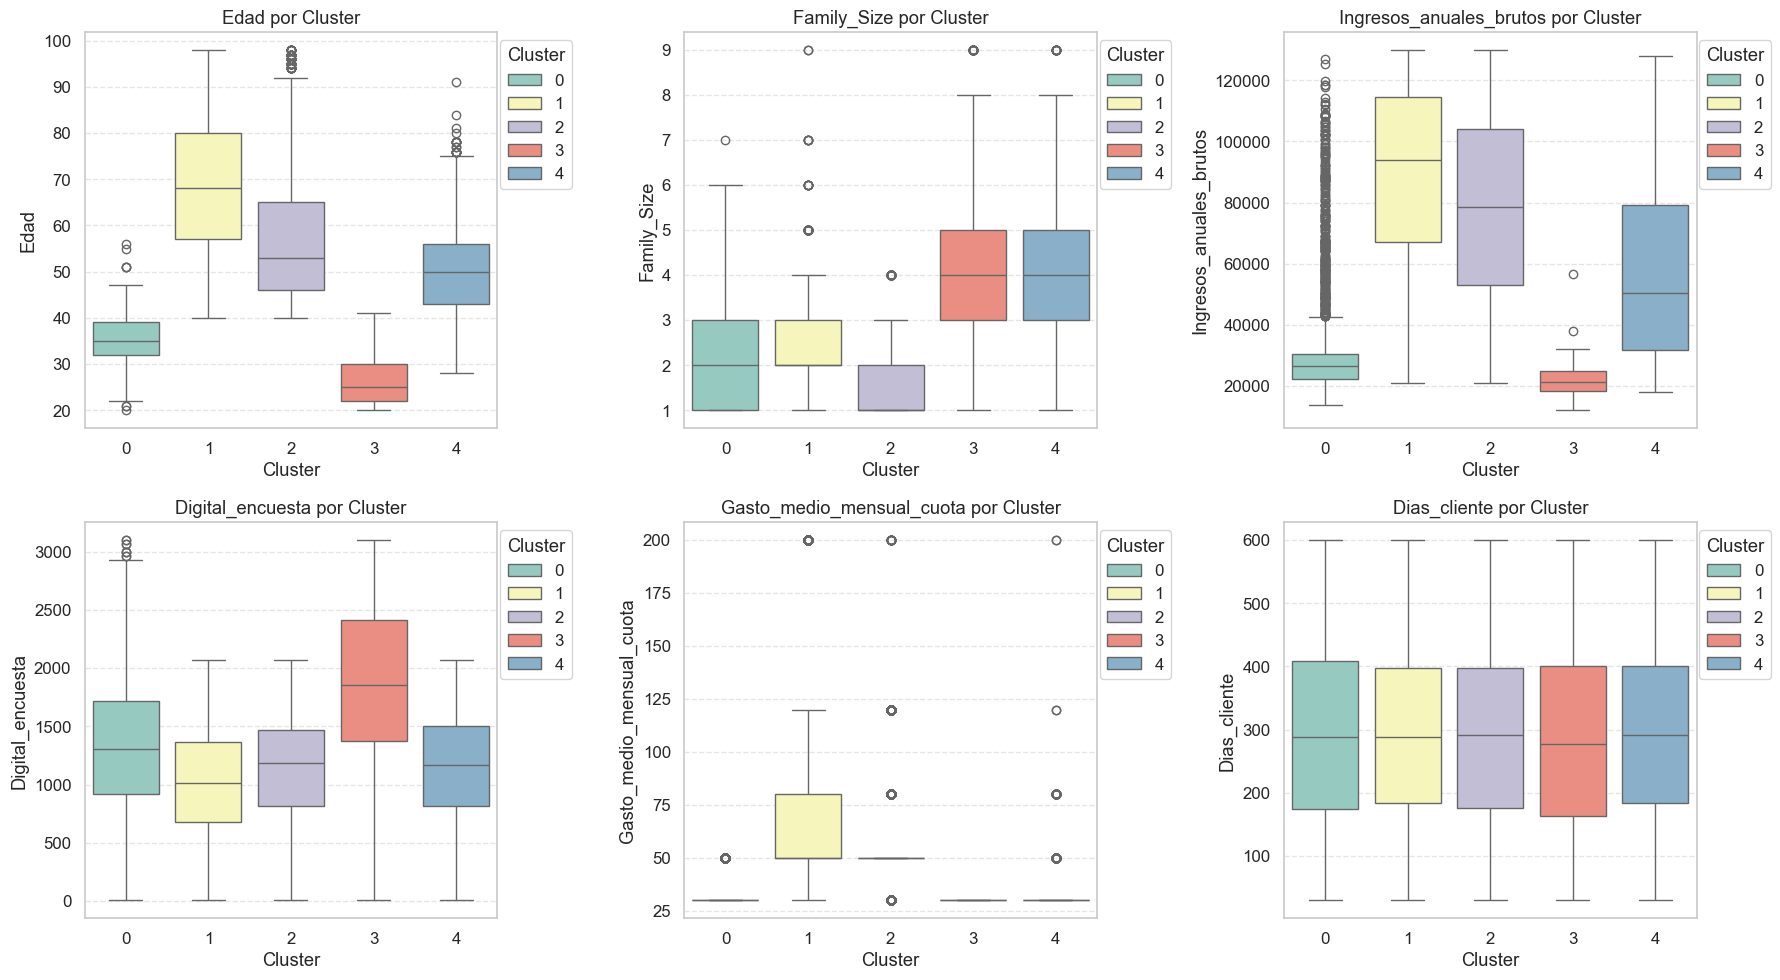

In [127]:
# Gráfica de boxplot para variables continuas por cluster.
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, var in enumerate([var for var in v_continuas if var not in [f"Campaña__{i}" for i in range(7)]]):
    sns.boxplot(data=df, x='Cluster_PCA', y=var, ax=axs[i], palette="Set3", hue='Cluster_PCA')
    axs[i].set_title(f'{var} por Cluster')
    axs[i].set_xlabel('Cluster')
    axs[i].set_ylabel(var)
    axs[i].legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))
    axs[i].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Análisis de Variables Continuas por Cluster** La segmentación realizada a través de PCA ha permitido identificar **5 perfiles de clientes** diferenciados, los cuales pueden analizarse en mayor profundidad a partir de sus **características numéricas clave**. A continuación, se argumentan las particularidades observadas en cada cluster, con base en las variables continuas:

**Cluster 0 – Jóvenes con bajo poder adquisitivo, alta proyección digital.**
- **Edad**: Es el grupo más joven junto con el cluster 3.
- **Ingresos brutos**: Presentan los ingresos más bajos.
- **Gasto mensual en cuota**: También reducido.
- **Digitalización**: Alto uso de canales digitales.
- **Días como cliente**: Tienen una antigüedad intermedia.

*Este grupo muestra bajo poder adquisitivo pero un fuerte componente digital. Se confirma su potencial como segmento para estrategias de captación digital, especialmente si se orientan hacia crecimiento y fidelización temprana.*

**Cluster 1 – Adultos consolidados, alto ingreso, bajo nivel digital.**
- **Edad**: El grupo más adulto de todos.
- **Ingresos brutos**: De los más altos, con gran dispersión.
- **Gasto mensual**: También es el más elevado.
- **Digitalización**: Niveles bajos.
- **Tamaño del hogar**: Más pequeño, como se esperaría de adultos independientes.

*Se reafirma como perfil ideal para estrategias de productos financieros premium y servicios de largo plazo. No son digitales, pero tienen alto valor individual.*

**Cluster 2 – Clientes de alto poder adquisitivo y comportamiento selectivo.**
- **Edad**: Promedio medio-alto.
- **Ingresos**: Muy altos, aunque algo más estables que el cluster 1.
- **Gasto mensual**: Uniformemente alto.
- **Digitalización**: Baja, pero no tan crítica como en otros grupos.
- **Antigüedad**: Ligeramente superior a otros.

*Confirma su perfil como cliente de valor, poco afectado por influencias digitales. Perfecto para experiencias premium, personalizadas y de valor percibido alto.*

**Cluster 3 – Jóvenes digitales con bajo ingreso y grandes familias.**
- **Edad**: Grupo más joven del conjunto.
- **Digitalización**: El más alto de todos.
- **Ingresos y gasto mensual**: Los más bajos.
- **Tamaño familiar**: Más alto que la media.

*Se consolida como grupo muy digital, joven y familiar. Son ideales para campañas dinámicas, promociones online y estrategias de retención a través de tecnología y contenido.*

**Cluster 4 – Madurez media, familias grandes y bajo gasto.**
- **Edad**: Intermedia-alta.
- **Ingresos**: Moderados.
- **Gasto mensual**: Bajo, a pesar de ingresos decentes.
- **Familias grandes** y **uso digital bajo**.

*Perfil conservador y práctico. Pueden responder a beneficios funcionales, propuestas tradicionales, packs familiares o soluciones de valor económico alto.*

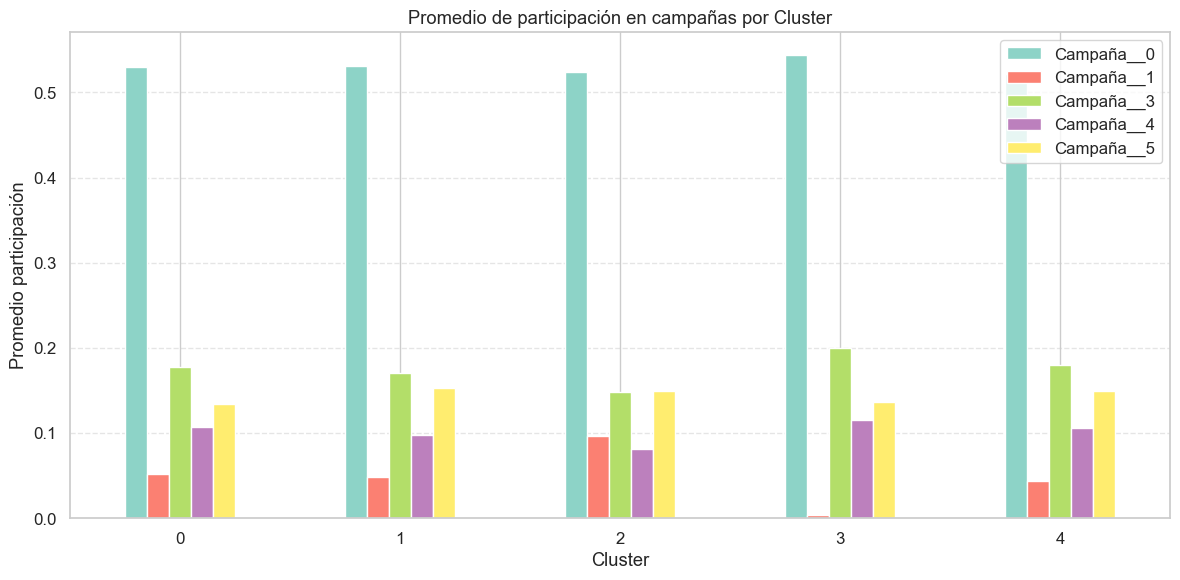

In [128]:
# Gráfica de barras para las variables de campaña.
campaign_means = df.groupby('Cluster_PCA')[[var for var in v_continuas if var in [f"Campaña__{i}" for i in range(7)]]].mean()

campaign_means.plot(kind='bar', figsize=(12, 6), colormap='Set3')
plt.title('Promedio de participación en campañas por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Promedio participación')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Análisis del Comportamiento en Campañas por Cluster.**

| Cluster | Comportamiento frente a campañas |
|---------|----------------------------------|
| **Cluster 0** | Participación moderada en campaña 0 y **más baja en el resto**. Responden algo mejor a campañas 3 y 5, pero en general su comportamiento muestra **baja reactividad**. |
| **Cluster 1** | Muy similar al Cluster 0: **respuesta más alta a la campaña 0** y más floja en el resto. Se nota una **ligera mejora en campaña 5**, lo que puede indicar una pequeña sensibilidad a campañas recientes. |
| **Cluster 2** | Aunque campaña 0 sigue siendo la más común, destaca con **una mayor participación en campaña 1**, superior al resto. Esto sugiere que **este grupo podría haber sido más receptivo a esa campaña específica**, quizás por su perfil económico. |
| **Cluster 3** | El grupo **menos expuesto a campaña 1**, pero el **más alto en campaña 3**. Esto puede indicar que **tienen preferencias diferentes o que responden mejor a contenidos específicos más recientes o digitales**. |
| **Cluster 4** | Patrón parecido a los clusters 0 y 1. Alta participación en campaña 0 y una **respuesta homogénea en el resto**. Ligeramente mejores en campañas 3 y 5, pero sin destacar demasiado. |

**Conclusión.**
- La **campaña 0** fue claramente la más masiva o generalista, ya que todos los clusters tienen una participación similar.
- El **cluster 2 destaca en campaña 1**, lo que puede revelar sensibilidad a estrategias más selectivas o exclusivas.
- El **cluster 3 responde mucho mejor a campaña 3**, probablemente por ser el grupo **más joven y digital**.
- El **resto de campañas (4 y 5)** mantienen un comportamiento regular, sin grandes diferencias, aunque **ligeramente mejores en los clusters 1 y 4**.

### **Caracterización por variables categóricas.**
En esta sección se analizan las variables categóricas del dataset con el objetivo de entender cómo se distribuyen los perfiles sociodemográficos y conductuales dentro de cada cluster. Este análisis permite identificar patrones de comportamiento y diferencias estructurales entre los grupos segmentados.

In [129]:
df[v_categoricas].head(3)

,Genero,Casado,Graduado,Experiencia_laboral,Gastoscore,Generacion,Abandono,Profesion,Zona
ID,,,,,,,,,
CLI10,Femenino,Sí,Sí,+20annos,Bajo,Generacion X,Sí,Técnico,Noroeste
CLI100,Masculino,Sí,Sí,+20annos,Medio,Generacion X,Sí,Técnico,Levante
CLI1000,Masculino,Sí,Sí,+20annos,Medio,Generacion X,No,Servicios,Centro


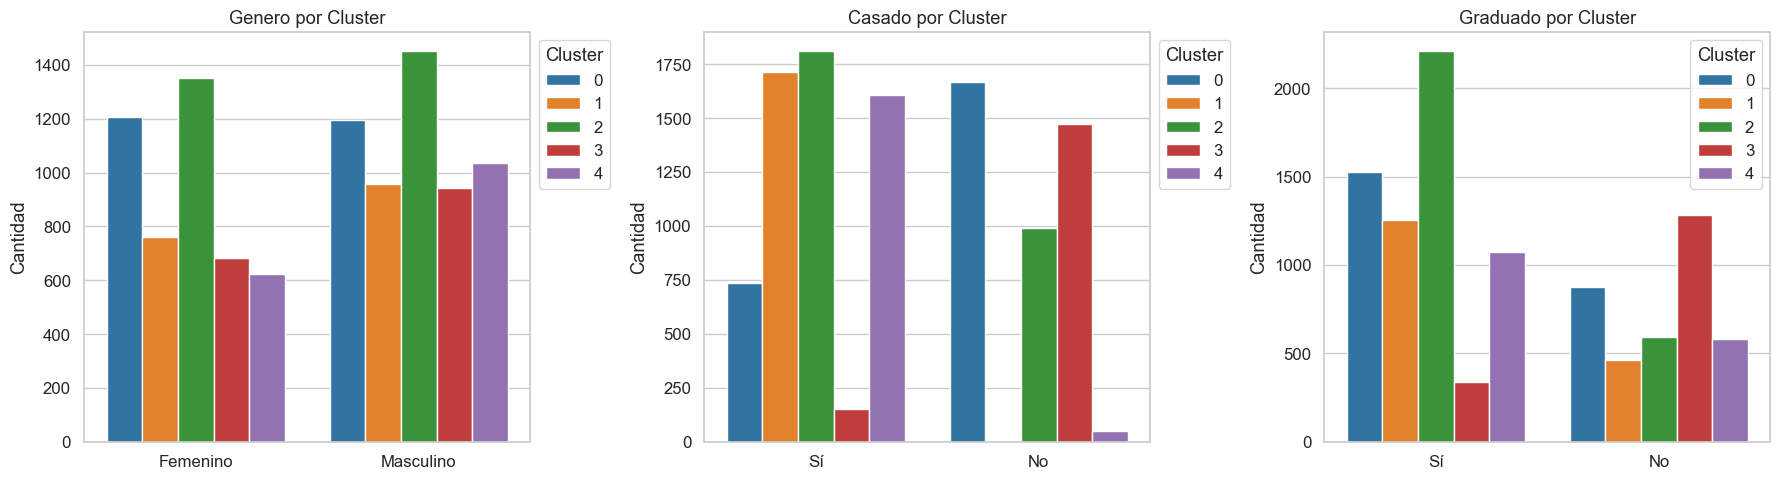

In [130]:
# Parte 1: Género, Casado y Graduado.
categorical_vars_1 = ['Genero', 'Casado', 'Graduado']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, var in zip(axes, categorical_vars_1):
    sns.countplot(data=df, x=var, hue='Cluster_PCA', palette='tab10', ax=ax)
    ax.set_title(f'{var} por Cluster')
    ax.set_xlabel('')
    ax.set_ylabel('Cantidad')
    ax.legend(title='Cluster', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

**Análisis de Variables Categóricas (I): Género, Casado y Graduado.**

| Variable   | Hallazgos por cluster |
|------------|------------------------|
| **Género** | La distribución por género es bastante equilibrada en todos los clusters, aunque el cluster 3 muestra una ligera mayoría masculina, mientras que el 2 se inclina por el femenino. |
| **Casado** | El cluster 1 agrupa principalmente personas casadas, mientras que el 0 y 3 destacan por una mayor proporción de personas solteras. |
| **Graduado** | El cluster 2 es el más académico (mayor proporción de graduados), mientras que el cluster 3 concentra el mayor porcentaje sin estudios universitarios. |

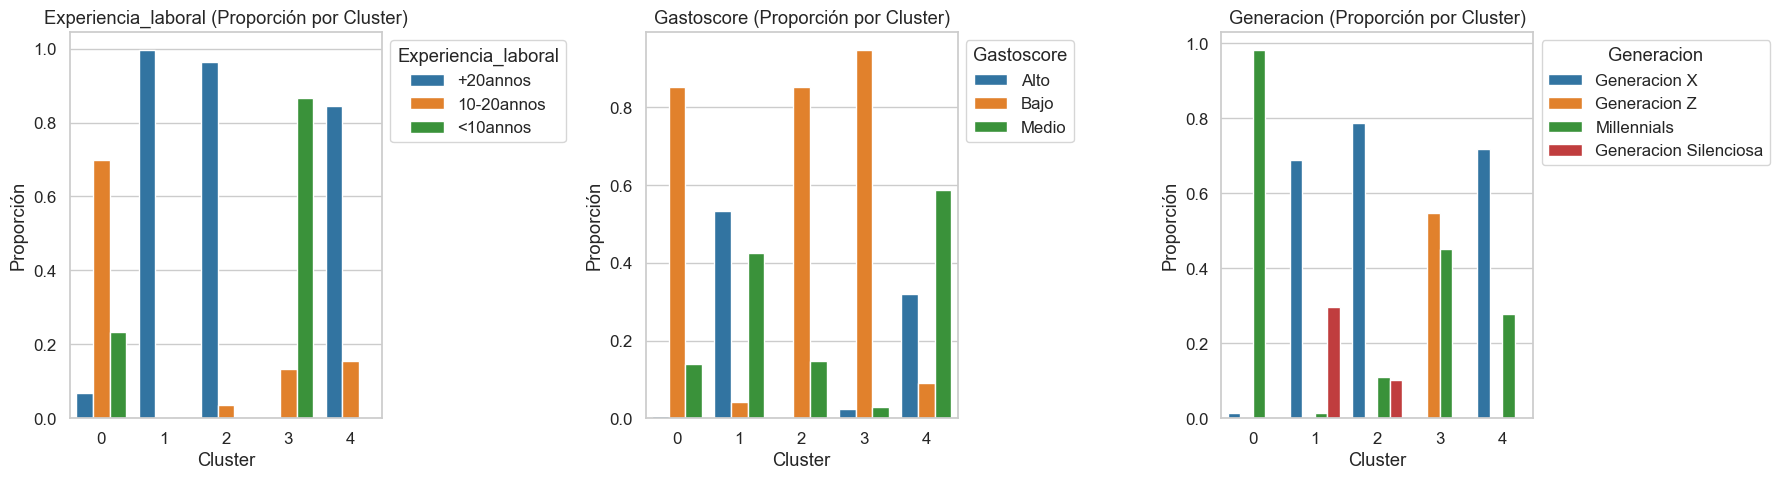

In [131]:
# Parte 2: Experiencia_laboral, Gastoscore, Generacion.
categorical_vars_2 = ['Experiencia_laboral', 'Gastoscore', 'Generacion']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, var in zip(axes, categorical_vars_2):
    prop_df = df.groupby(['Cluster_PCA', var]).size().reset_index(name='count')
    total = prop_df.groupby('Cluster_PCA')['count'].transform('sum')
    prop_df['proporcion'] = prop_df['count'] / total

    sns.barplot(
        data=prop_df,
        x='Cluster_PCA', y='proporcion', hue=var,
        ax=ax, palette='tab10'
    )
    ax.set_title(f'{var} (Proporción por Cluster)')
    ax.set_ylabel('Proporción')
    ax.set_xlabel('Cluster')
    ax.legend(title=var, bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

**Análisis de Variables Categóricas (II): Experiencia, Gasto y Generación.**

| Variable                 | Hallazgos por cluster |
|--------------------------|------------------------|
| **Experiencia laboral** | El cluster 1 se compone mayoritariamente de perfiles con más de 20 años de experiencia, lo que refuerza su perfil consolidado. El cluster 3, en cambio, concentra a los menos experimentados (<10 años), mientras que el cluster 0 agrupa principalmente experiencia media. |
| **Gasto Score**          | El cluster 0 tiene una clara mayoría con score **bajo**, reflejando menor capacidad o hábitos de consumo. Clusters 1 y 2 destacan por presencia de **score medio y alto**, lo que valida su perfil económico más robusto. |
| **Generación**          | El cluster 0 está compuesto casi exclusivamente por **Millennials** (98%), mientras que el cluster 3 se distingue por una mayoría de **Generación Z** (63%). El cluster 2 es mayoritariamente **Generación X** (80%), y el cluster 1 combina **Generación X** y **Silenciosa**, formando el grupo más adulto y tradicional. |

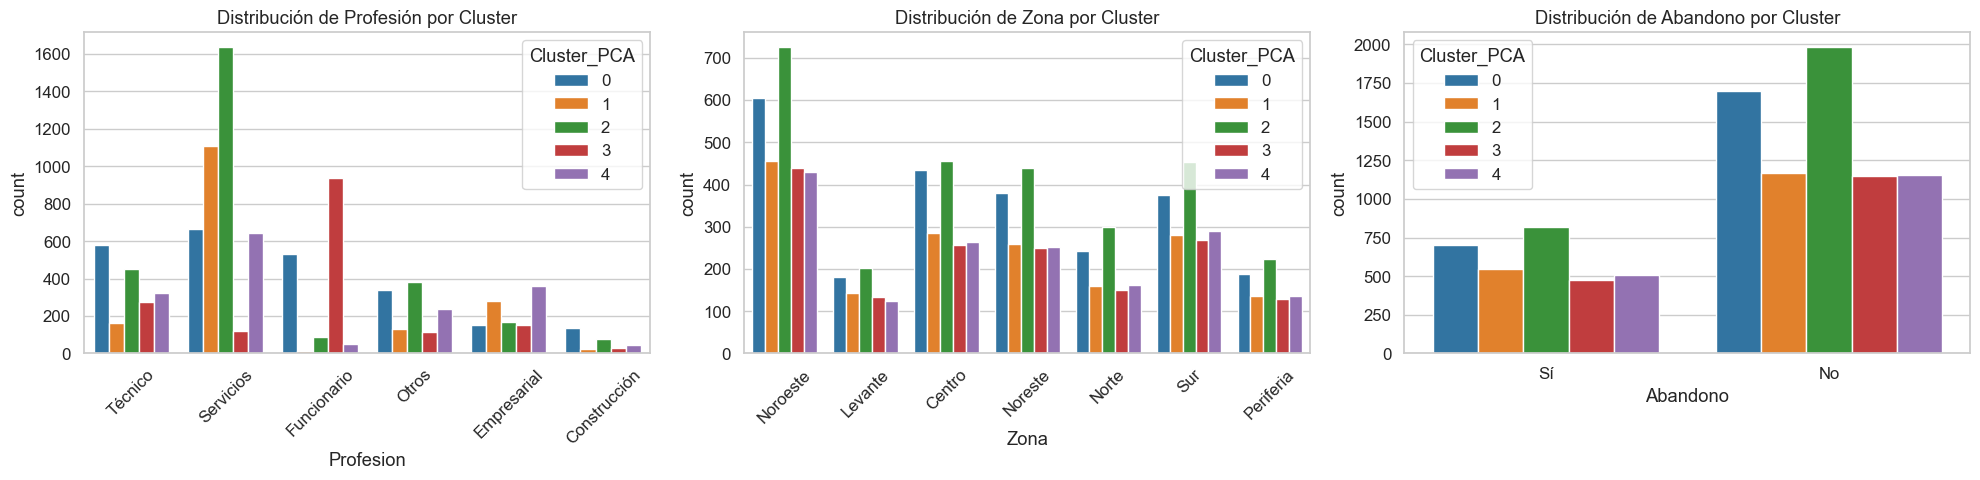

In [132]:
# Crear gráficos para Profesión, Zona y Abandono
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Profesión.
sns.countplot(data=df, x='Profesion', hue='Cluster_PCA', palette='tab10', ax=axes[0])
axes[0].set_title('Distribución de Profesión por Cluster')
axes[0].tick_params(axis='x', rotation=45)

# Zona.
sns.countplot(data=df, x='Zona', hue='Cluster_PCA', palette='tab10', ax=axes[1])
axes[1].set_title('Distribución de Zona por Cluster')
axes[1].tick_params(axis='x', rotation=45)

# Abandono.
sns.countplot(data=df, x='Abandono', hue='Cluster_PCA', palette='tab10', ax=axes[2])
axes[2].set_title('Distribución de Abandono por Cluster')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

**Análisis de Variables Categóricas (II): Profesión, Zona geográfica y Abandono.**

| Variable     | Hallazgos por cluster |
|--------------|------------------------|
| **Profesión** | **Cluster 0** es diverso, con equilibrio entre técnicos, servicios y funcionarios. **Cluster 1** se concentra fuertemente en el sector **Servicios**. **Cluster 2** combina servicios con técnicos y otros perfiles. **Cluster 3** está dominado por **funcionarios**, siendo el más homogéneo. **Cluster 4** es el más equilibrado, con mezcla de empresariales, técnicos y servicios. |
| **Zona geográfica** | Todos los clusters presentan una distribución bastante similar. **El Noroeste** es la zona más frecuente en todos los grupos, seguido por **Centro** y **Noreste**. Las zonas de **Periferia** y **Levante** tienen menor presencia relativa. No hay un patrón geográfico diferenciador fuerte, pero el **Cluster 1** y el **Cluster 3** tienen una ligera mayor representación en el **Noroeste**.  |
| **Abandono** | Todos los clusters presentan tasas similares de abandono. El **Cluster 2** y el **Cluster 3** tienen la proporción **más baja de abandono**, lo que sugiere mayor estabilidad o satisfacción. El **Cluster 1** muestra la tasa **ligeramente más alta**, lo que podría indicar una sensibilidad mayor ante fallos en la experiencia o expectativas más altas. |

### **Naming Estratégico de los Clusters.**
Después de analizar en profundidad las variables continuas y categóricas, podemos sintetizar el comportamiento de cada grupo en un perfil tipo. Este proceso de naming estratégico nos permite asignar a cada cluster una etiqueta descriptiva y fácil de comunicar, que resume sus características clave.

El objetivo es facilitar la comprensión y la aplicación práctica de los resultados por parte del equipo de negocio, marketing o atención al cliente. Cada nombre resume la esencia sociodemográfica, económica y conductual del segmento.

A continuación, se presenta una tabla resumen con el perfil de cada cluster y su denominación propuesta.

| Cluster | Nombre conceptual                          | Nombre marketing     | Perfil resumido |
|---------|--------------------------------------------|----------------------|------------------|
| **0**   | *Jóvenes digitales de bajo ingreso*        | *Digital Starters*   | Clientes jóvenes, altamente digitalizados, con bajo poder adquisitivo. Profesiones técnicas o públicas. Ideales para campañas digitales de captación temprana. |
| **1**   | *Adultos tradicionales con alto ingreso*   | *Golden Offline*     | Adultos mayores o de mediana edad, ingresos elevados, casados, baja digitalización. Estables, ideales para productos premium y asistencia personalizada. |
| **2**   | *Clientes premium rentables*               | *VIP Loyals*         | Alta capacidad de gasto, bajo abandono, perfil profesional consolidado. Muy rentables, perfectos para estrategias de fidelización de valor. |
| **3**   | *Generación Z en hogares amplios*          | *Zoomer Families*    | Clientes muy jóvenes, altamente digitales y con familias numerosas. Responden a promociones online, ideal para gamificación y campañas móviles. |
| **4**   | *Hogares amplios de potencial contenido*   | *Family Boosters* | Clientes ligeramente mayores, con familias numerosas y profesiones variadas. Aunque su gasto actual es moderado, el sistema los clasifica con alto potencial financiero. Baja interacción digital, pero muestran algo más de respuesta en campañas recientes. Ideales para propuestas prácticas o familiares, con una mirada a largo plazo. |

In [133]:
clusters_info = {
    "0": {
        "nombre_marketing": "Digital Starters",
        "nombre_conceptual": "Jóvenes digitales de bajo ingreso",
        "descripcion": "Clientes jóvenes, altamente digitalizados, con bajo poder adquisitivo. Profesiones técnicas o públicas. Ideales para campañas digitales de captación temprana."
    },
    "1": {
        "nombre_marketing": "Golden Offline",
        "nombre_conceptual": "Adultos tradicionales con alto ingreso",
        "descripcion": "Adultos mayores o de mediana edad, ingresos elevados, casados, baja digitalización. Estables, ideales para productos premium y asistencia personalizada."
    },
    "2": {
        "nombre_marketing": "VIP Loyals",
        "nombre_conceptual": "Clientes premium rentables",
        "descripcion": "Alta capacidad de gasto, bajo abandono, perfil profesional consolidado. Muy rentables, perfectos para estrategias de fidelización de valor."
    },
    "3": {
        "nombre_marketing": "Zoomer Families",
        "nombre_conceptual": "Generación Z en hogares amplios",
        "descripcion": "Clientes muy jóvenes, altamente digitales y con familias numerosas. Responden a promociones online, ideal para gamificación y campañas móviles."
    },
    "4": {
        "nombre_marketing": "Family Boosters",
        "nombre_conceptual": "Hogares amplios de potencial contenido",
        "descripcion": "Clientes ligeramente mayores, con familias numerosas y profesiones variadas. Aunque su gasto actual es moderado, el sistema los clasifica con alto potencial financiero. Baja interacción digital, pero muestran algo más de respuesta en campañas recientes. Ideales para propuestas prácticas o familiares, con una mirada a largo plazo."
    }
}

# Convertir a JSON.
json_output = json.dumps(clusters_info, indent=4, ensure_ascii=False)
with open("../data/report/IA_Client_Segment_sample_Cluster.json", "w", encoding="utf-8") as f:
    f.write(json_output)

In [134]:
df.to_csv('../data/processed/IA_Client_Segment_sample_v3.csv', index=True) # Guardar el dataset final.